# Load Processed Dataset


In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print(f"Saving figure {fig_id} at {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

df = pd.read_csv("../data/preprocessed.csv")
df.head()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,1st - approved,1st - grade,1st - no evaluations,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations,Target
0,1,0,5,1,1,0,122.0,0,0,1,...,0,0.000000,0,0,0,0,0,0.000000,0,Dropout
1,1,4,1,3,1,0,160.0,0,1,2,...,6,14.000000,0,0,6,6,6,13.666667,0,Graduate
2,1,0,5,1,1,0,122.0,0,0,0,...,0,0.000000,0,0,6,0,0,0.000000,0,Dropout
3,1,0,2,1,1,0,122.0,0,0,0,...,6,13.428571,0,0,6,10,5,12.400000,0,Graduate
4,0,2,1,5,0,0,100.0,0,0,0,...,5,12.333333,0,0,6,6,6,13.000000,0,Graduate


In [2]:
df.describe()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,1st - evaluations,1st - approved,1st - grade,1st - no evaluations,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.885850,0.864828,1.727848,2.787975,0.890823,0.107369,132.613314,0.008137,0.672920,0.533228,...,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316
std,0.318029,1.156445,1.313793,1.517635,0.311897,0.309617,13.188332,0.089850,0.964169,0.906319,...,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,125.000000,0.000000,0.000000,0.000000,...,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000
50%,1.000000,0.000000,1.000000,3.000000,1.000000,0.000000,133.100000,0.000000,0.000000,0.000000,...,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000
75%,1.000000,2.000000,2.000000,4.000000,1.000000,0.000000,140.000000,0.000000,1.000000,1.000000,...,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000
max,1.000000,4.000000,9.000000,5.000000,1.000000,1.000000,190.000000,1.000000,4.000000,4.000000,...,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000


# Pre-train


In [3]:
# Choose numeic features
numeric_cols = [
    'Application order', 'Admission grade', 'Pre Qual (grade)',
    '1st - enrolled', '1st - evaluations',  '1st - approved', 
    '2nd - enrolled', '2nd - evaluations',  '2nd - approved',
    'Enroll Age' 
]

# Choose categorical features
categorical_cols = [
    'Marial Status', 'Application mode', 'Course', 'Pre Qual',
    'Daytime/Evening', 'Scholarship', 'Tuition fees up to date',
    'Displaced', 'Gender', 'International',
    "Mom's Qual", "Mom's Occupation",
    "Dad's Qual", "Dad's Occupation"
]

# Map labels
label_map = {"Graduate": 0, "Enrolled": 1, "Dropout": 2}
df['Target'] = df['Target'].map(label_map)

X = df[numeric_cols + categorical_cols]
y = df['Target']

In [4]:
# Create processor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='drop'
)

# Train Models


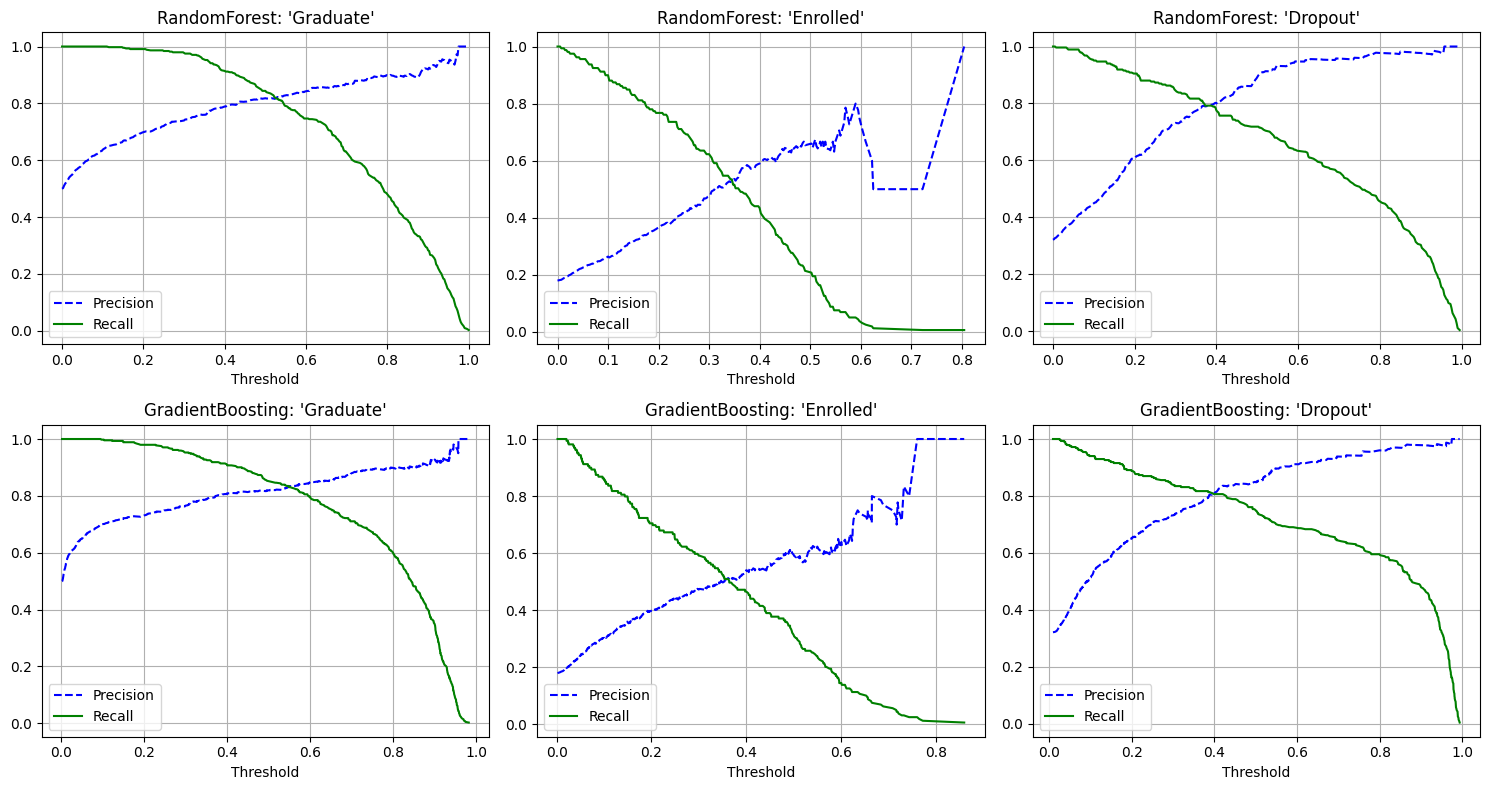

Saving figure precision_recall_curve at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/precision_recall_curve.png


<Figure size 640x480 with 0 Axes>

In [5]:
# Define train pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
models = {
    'RandomForest': RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, class_weight='balanced_subsample', n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # --- Plot precision-recall vs threshold for all classes as subplots ---
    # For each model, store scores for each class
    if not 'prc_scores' in globals():
        prc_scores = {}
    prc_scores[name] = {}

    for i, class_lbl in enumerate(sorted(y.unique())):
        # Get scores for this class
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_scores = pipe.predict_proba(X_test)[:, i]
        else:
            # fallback for estimators that don't have predict_proba
            if hasattr(pipe.named_steps['model'], "decision_function"):
                y_scores = pipe.decision_function(X_test)
                if y_scores.ndim > 1:
                    y_scores = y_scores[:, i]
            else:
                y_scores = None
        if y_scores is not None:
            y_test_bin = (y_test == class_lbl).astype(int)
            precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_scores)

            prc_scores[name][class_lbl] = (precisions, recalls, thresholds)

    # If last model, plot all subplots
    if name == list(models.keys())[-1]:
        n_models = len(models)
        n_classes = len(sorted(y.unique()))
        fig, axes = plt.subplots(n_models, n_classes, figsize=(5 * n_classes, 4 * n_models), squeeze=False)
        class_name_map = {v: k for k, v in label_map.items()} if "label_map" in globals() else {c: str(c) for c in range(n_classes)}

        for row_i, (model_name, class_dict) in enumerate(prc_scores.items()):
            for col_i, class_lbl in enumerate(sorted(class_dict.keys())):
                precisions, recalls, thresholds = class_dict[class_lbl]
                ax = axes[row_i, col_i]
                ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
                ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
                ax.set_xlabel("Threshold")
                ax.set_title(f"{model_name}: '{class_name_map.get(class_lbl, class_lbl)}'")
                ax.legend(loc="best")
                ax.grid(True)
        plt.tight_layout()
        plt.show()

    # Evaluate model
    try:
        if hasattr(pipe.named_steps['model'], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        else:
            roc_auc = None
    except Exception:
        roc_auc = None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'roc_auc_ovr': roc_auc,
        'pipeline': pipe
    }
    
save_fig('precision_recall_curve')

In [12]:
pd.DataFrame(results).T

,accuracy,f1_macro,f1_weighted,precision_macro,precision_weighted,recall_macro,recall_weighted,roc_auc_ovr,pipeline
RandomForest,0.769492,0.696647,0.757046,0.725448,0.757467,0.685157,0.769492,0.878347,"(ColumnTransformer(transformers=[('num', Robus..."
GradientBoosting,0.783051,0.718451,0.774273,0.737902,0.772495,0.708721,0.783051,0.882816,"(ColumnTransformer(transformers=[('num', Robus..."


# Report


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       442
           1       0.58      0.43      0.49       159
           2       0.82      0.80      0.81       284

    accuracy                           0.78       885
   macro avg       0.74      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885



# Confusion Matrix


Saving figure confusion_matrix at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/confusion_matrix.png


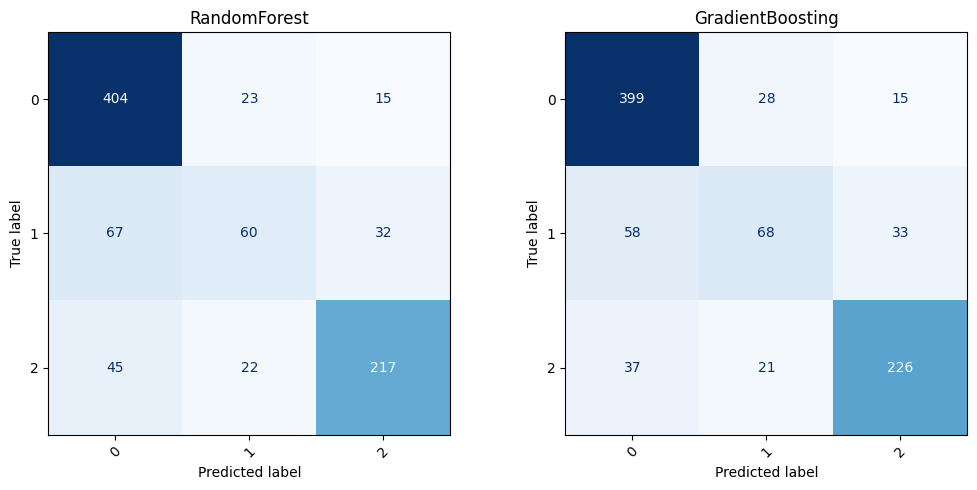

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_names = list(results.keys())
y_preds = []
for model in model_names:
    pipe = results[model].get('pipeline')
    if pipe is not None:
        y_pred_model = pipe.predict(X_test)
    else:
        y_pred_model = y_pred
    y_preds.append(y_pred_model)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for idx, (model, y_pred_model) in enumerate(zip(model_names, y_preds)):
    cm = confusion_matrix(y_test, y_pred_model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', xticks_rotation=45, colorbar=False)
    axes[idx].set_title(f"{model}")
plt.tight_layout()
save_fig('confusion_matrix')

# Top 10 Feature Importances


/var/folders/8h/flfm2ytd5sj2w44x8_421m9w0000gn/T/ipykernel_9713/2737083413.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(model_top_data))


Saving figure top_10_feature_importances_overlap at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/top_10_feature_importances_overlap.png


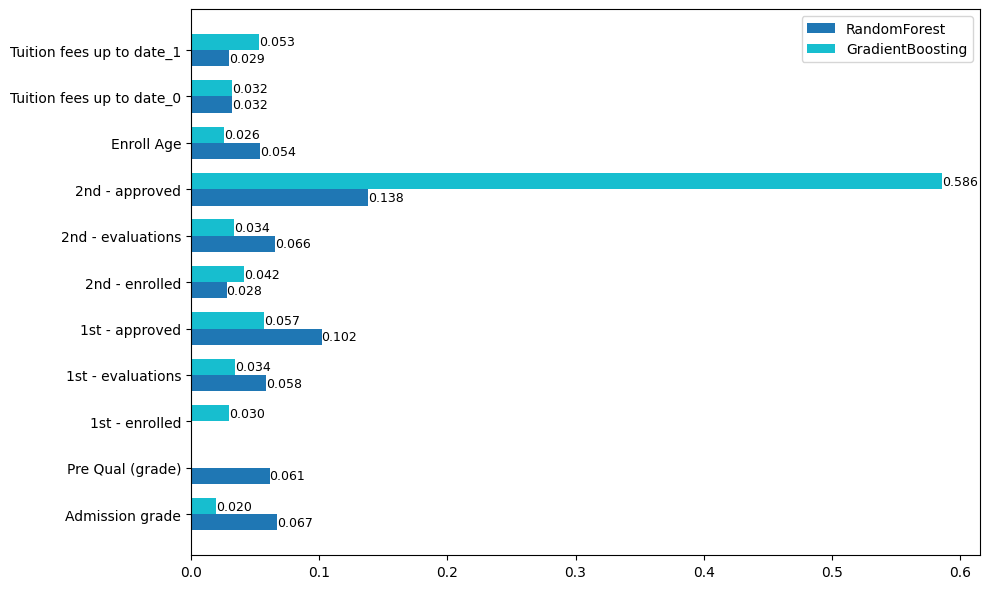

In [13]:
# Extract feature names after preprocessing
prep = preprocessor
feature_names = []

# Numeric features first (scaler doesn't change names)
feature_names.extend(numeric_cols)

# Then categorical one-hot names
for name, trans, cols in prep.transformers_:
    if name == 'cat':
        ohe = trans
        if hasattr(ohe, 'get_feature_names_out'):
            cat_feature_names = list(ohe.get_feature_names_out(cols))
        else:
            # Fallback for older sklearn
            cat_feature_names = []
            try:
                for i, col in enumerate(cols):
                    categories = ohe.categories_[i]
                    cat_feature_names.extend([f"{col}_{cat}" for cat in categories])
            except Exception:
                pass
        feature_names.extend(cat_feature_names)

# If pipeline reordered or dropped columns, guard with X_train columns length
if len(feature_names) == 0 or len(feature_names) != preprocessor.transform(X_train[:1]).shape[1]:
    try:
        feature_names = [f"f{i}" for i in range(preprocessor.transform(X_train[:1]).shape[1])]
    except Exception:
        feature_names = [f"f{i}" for i in range(len(numeric_cols) + len(feature_names))]

# Plot for each model that supports feature_importances_

import matplotlib.cm as cm

top_k = 10
feature_top_indices = set()
model_top_data = {}

# Collect top-k features and their importances per model
for model_name, info in results.items():
    pipe = info.get('pipeline')
    if pipe is None:
        continue

    model = pipe.named_steps['model']
    if not hasattr(model, 'feature_importances_'):
        continue

    importances = model.feature_importances_
    if importances is None or len(importances) != len(feature_names):
        print(f"Skipping {model_name} due to feature_importances_ shape mismatch.")
        continue

    indices = np.argsort(importances)[-top_k:][::-1]
    feature_top_indices.update(indices)
    model_top_data[model_name] = (indices, importances[indices])

if not model_top_data:
    print("No models with valid feature_importances_ found.")
else:
    # Only features that appeared in any model's top_k list
    full_indices = sorted(feature_top_indices)
    feature_label_map = {i: feature_names[i] for i in full_indices}
    n_features = len(full_indices)

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = cm.get_cmap('tab10', len(model_top_data))

    bar_width = 0.35
    step = bar_width * len(model_top_data)
    bar_positions = np.arange(n_features)

    # Barh for each model's top importances, mapped to the overlap x-axis
    bar_containers = []
    for idx, (model_name, (indices, vals)) in enumerate(model_top_data.items()):
        y = np.zeros(n_features)
        for i, val in zip(indices, vals):
            if i in full_indices:
                y[full_indices.index(i)] = val
        bars = ax.barh(
            bar_positions + idx * bar_width,
            y,
            height=bar_width,
            label=model_name,
            color=colors(idx)
        )
        bar_containers.append((bars, y))

    ax.set_yticks(bar_positions + bar_width * (len(model_top_data) - 1) / 2)
    ax.set_yticklabels([feature_label_map[i] for i in full_indices])
    ax.legend()
    plt.tight_layout()
    save_fig('top_10_feature_importances_overlap')

    # Add importance value labels next to each bar
    for idx, (bars, y) in enumerate(bar_containers):
        for bar, val in zip(bars, y):
            if val > 0:  # Show only for nonzero importances
                ax.text(
                    bar.get_width(),
                    bar.get_y() + bar.get_height()/2,
                    f"{val:.3f}",
                    va='center',
                    ha='left',
                    fontsize=9
                )

    plt.show()